In [1]:
%%bash
[[ ! -e /content/sample_data ]] && exit  ## run this cell only in colab
 
pip install optax -qqq
pip install networkx==2.5 -qqq
pip install netgraph
git clone https://github.com/ramithuh/differentiable-trees --quiet

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

if(os.path.exists('/content/sample_data')):
  sys.path.append('differentiable-trees/')

import jax.numpy as jnp
import jax.nn as nn
import jax
import optax
import functools

import pydot
import numpy as np
from helpers import *

from matplotlib import rc
rc('animation', html='jshtml')

In [3]:
key = jax.random.PRNGKey(42)

## Sequences

In [4]:
# sequences (fixed)
n_leaves    = 7
n_ancestors = n_leaves - 1

seq_length = 4

n_all = n_leaves + n_ancestors

metadata = {
            'n_all' : n_all,
            'n_leaves' : n_leaves, 
            'n_ancestors' : n_ancestors 
            }

blank = jnp.array([0,0,0,0])

In [5]:
# similarity matrix (fixed)
sm = jnp.array([[0,1],
               [1,0]])

In [6]:
seqs = jax.random.randint(key, shape = (n_all, seq_length), minval = 0, maxval = 2)

In [7]:
base_tree = jnp.zeros((n_all, n_all))

In [8]:
seqs

DeviceArray([[1, 0, 1, 0],
             [0, 1, 1, 0],
             [1, 1, 1, 0],
             [1, 0, 0, 0],
             [0, 0, 0, 0],
             [1, 0, 1, 1],
             [1, 0, 1, 1],
             [0, 1, 0, 1],
             [0, 1, 0, 1],
             [1, 0, 1, 1],
             [0, 0, 0, 0],
             [0, 0, 1, 1],
             [1, 1, 1, 0]], dtype=int32)

## Tree Topology (also parameterized)

### initialize parameters

In [9]:
optimizer = optax.adam(1)

params = {'t': jax.random.normal(key, (n_all - 1,n_ancestors))}


for i in range(0, n_ancestors):
    params[chr(97+i + n_leaves)] = jax.random.normal(key, (seq_length,))
    

opt_state = optimizer.init(params)

In [10]:
params.keys()

dict_keys(['t', 'h', 'i', 'j', 'k', 'l', 'm'])

In [11]:
# t_q = jnp.argmax(t_softmax,axis = 1).T

In [12]:
base_tree.shape

(13, 13)

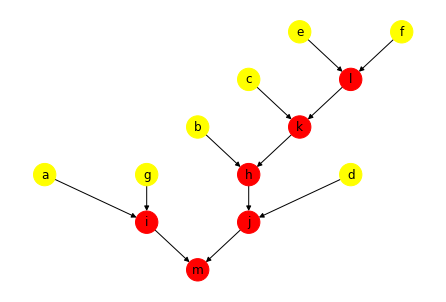

In [13]:
show_graph_with_labels(discretize_tree_topology(update_tree(params, base_tree), n_all),n_leaves)

### Function to compute total distance

In [14]:
def compute_cost(sequences, tree, verbose = False, average = True):
    if(verbose==True):
        show_graph_with_labels(discretize_tree_topology(tree, n_all),n_leaves)
        
    selection = jnp.matmul(tree,sequences)
    # print(selection)
    
#     #method 1: (downside needs integers as we are indexing)
#     selection = selection.astype(int)
#     ans = sm[selection,sequences].sum()
    
    #method 2:
    if(average):
        ans = abs(selection - sequences).sum() ## works currently as sm is the basic config. need to think about extending
    else:
        ans = jnp.sum(abs(selection - sequences), axis = 1)
    
    return ans

In [15]:
update_tree(params, base_tree)

DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.13910422, 0.34845117, 0.21330582,
              0.04044172, 0.14791861, 0.11077841],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.27657446, 0.17563644, 0.07084966,
              0.15842403, 0.07731151, 0.24120387],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.10724179, 0.08720998, 0.19859421,
              0.30010968, 0.12557727, 0.18126707],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.06070831, 0.10982104, 0.3455469 ,
              0.14241804, 0.15635832, 0.18514742],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.10889674, 0.03192557, 0.16744772,
              0.02538426, 0.5823018 , 0.08404393],
     

DeviceArray(22.603205, dtype=float32)

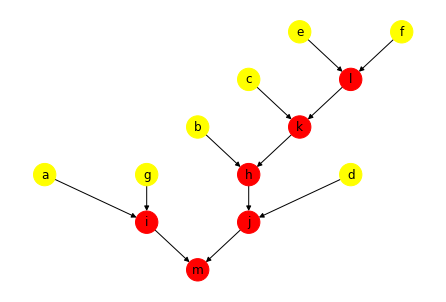

In [16]:
compute_cost(seqs,update_tree(params, base_tree),1)

In [17]:
params

{'t': DeviceArray([[ 0.05399319,  0.97226787,  0.48149663, -1.1813684 ,
                0.11543203, -0.1736983 ],
              [ 0.4207868 , -0.03327714, -0.94113314, -0.1364181 ,
               -0.8538505 ,  0.28394914],
              [-0.8156667 , -1.0224338 , -0.19948915,  0.21339531,
               -0.65783155, -0.2907813 ],
              [-0.94912165, -0.35635012,  0.7899262 , -0.09643552,
               -0.00305201,  0.16595015],
              [ 0.27988997, -0.94710296,  0.710161  , -1.1763811 ,
                1.9564787 ,  0.02082947],
              [-0.31057647, -0.22797403,  1.1147015 ,  0.2864924 ,
                1.5819802 , -0.67858696],
              [-0.98748755,  1.3398945 ,  0.7911485 , -0.26759598,
                0.8042011 , -0.24085546],
              [ 0.3299379 ,  0.47771922,  0.7259686 , -0.43510723,
                0.6885145 , -0.0347344 ],
              [ 1.1832725 ,  2.0837178 , -0.23368722,  0.36153802,
                0.28805566,  2.218827  ],
              

In [18]:
n_all

13

In [19]:
# tree_force_loss = 0 

# t_new = discretize_tree_topology(update_tree(params, base_tree), n_leaves + n_ancestors)

# for k in range(n_all - 1, n_all - 1 - n_ancestors, -1):
#     tree_force_loss += (abs(t_new[:-1,k].sum()-2))**2

# print(tree_force_loss)

In [20]:
def regularize_graph(t_, s, verbose = False):
    
    tree_force_loss = jnp.sum(jnp.power(s*jnp.abs(jnp.sum(t_[:-1, n_all - n_ancestors: n_all], axis = 0) - 2),2))
    
    #tree_force_loss = (s*abs(t_[:-1,-2].sum()-2))**2 + (s*abs(t_[:-1,-1].sum()-2))**2
    
    loop_loss = jnp.multiply(jnp.identity(n_all-1), t_[:-1,:-1]).sum()*100  ## penalize self connections
    
    
    if(verbose):
        print("bifurcating tree_forcing_loss = ", tree_force_loss)
        print("self loop_loss = ", loop_loss)
    
    return tree_force_loss + loop_loss

In [21]:
def compute_loss(params, seqs, base_tree, verbose = False):
    seqs_ = combine_to_seq(params, seqs, n_leaves, n_all)
    t_    = update_tree(params, base_tree)

    loss  = compute_cost(seqs_,t_) + enforce_graph(t_,10,metadata, verbose)
    
    return loss

In [22]:
compute_loss(params, seqs, base_tree)

/n/home12/ramith/.local/lib/python3.8/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


DeviceArray(146.32368, dtype=float32)

In [23]:
trees = []

for _ in range(1500):
    grads = jax.grad(compute_loss)(params, seqs, base_tree)
    
    
    t_= update_tree(params, base_tree)
    t__ = discretize_tree_topology(t_,n_all)
    t__ = t__.at[-1,-1].set(0)
    
    trees.append(t__)
    
    if(_%100==0):
        # temp  = combine_to_seq(params, seqs)
        
        print("{:.5f}".format(compute_loss(params, seqs, base_tree)),end = " seq = {}\n")
        #print(t_[:,-2],",",t_[:,-1],end="}\n")
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


146.32368 seq = {}
18.04161 seq = {}
18.00309 seq = {}
17.99414 seq = {}
17.99013 seq = {}
17.98855 seq = {}
17.98618 seq = {}
17.98509 seq = {}
17.98414 seq = {}
17.98308 seq = {}
17.98088 seq = {}
17.22717 seq = {}
18.00395 seq = {}
18.00224 seq = {}
18.00159 seq = {}


In [24]:
adjacency_matrix2 = jnp.array(trees)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/n/home12/ramith/.conda/envs/jax_python38/lib/python3.8/site-packages/netgraph/_utils.py:395: RuntimeWarning: invalid value encountered in divide
  unit_vector = vector / np.linalg.norm(vector)


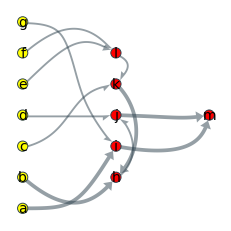

In [25]:
anim = animate_tree(adjacency_matrix2, n_leaves, n_ancestors, total_frames = 500 )

In [26]:
#anim.save(f"nodes_{n_all}.mp4")

In [27]:
t_new = discretize_tree_topology(update_tree(params, base_tree), n_leaves + n_ancestors)

In [28]:
discretized = jnp.round(combine_to_seq(params, seqs, n_leaves, n_all))

/n/home12/ramith/.local/lib/python3.8/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [29]:
compute_loss(params, seqs, base_tree, 1)

bifurcating tree_forcing_loss =  0.0009646257
self loop_loss =  0.00014244938
bidirectional loss =  1.0000229


DeviceArray(18.001236, dtype=float32)

In [30]:
t_new

DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],            dtype=float32)

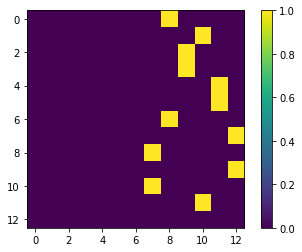

In [31]:
plt.imshow(adjacency_matrix2[300])
plt.colorbar()

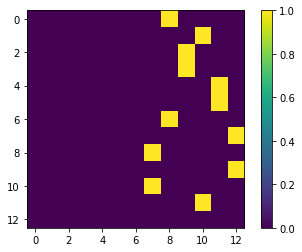

In [32]:
plt.imshow(adjacency_matrix2[-1])
plt.colorbar()


## Retrieving the new sequences array

In [33]:
t_new = discretize_tree_topology(update_tree(params, base_tree), n_leaves + n_ancestors)

In [34]:
combine_to_seq(params, seqs, n_leaves, n_all)

DeviceArray([[1, 0, 1, 0],
             [0, 1, 1, 0],
             [1, 1, 1, 0],
             [1, 0, 0, 0],
             [0, 0, 0, 0],
             [1, 0, 1, 1],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [1, 1, 1, 0]], dtype=int32)

In [35]:
discretized = jnp.round(combine_to_seq(params, seqs, n_leaves, n_all))

In [36]:
discretized

DeviceArray([[1, 0, 1, 0],
             [0, 1, 1, 0],
             [1, 1, 1, 0],
             [1, 0, 0, 0],
             [0, 0, 0, 0],
             [1, 0, 1, 1],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [1, 1, 1, 0]], dtype=int32)

In [37]:
seqs

DeviceArray([[1, 0, 1, 0],
             [0, 1, 1, 0],
             [1, 1, 1, 0],
             [1, 0, 0, 0],
             [0, 0, 0, 0],
             [1, 0, 1, 1],
             [1, 0, 1, 1],
             [0, 1, 0, 1],
             [0, 1, 0, 1],
             [1, 0, 1, 1],
             [0, 0, 0, 0],
             [0, 0, 1, 1],
             [1, 1, 1, 0]], dtype=int32)

In [38]:
params

{'h': DeviceArray([ 0.18693547,  1.0653336 , -1.5593132 , -1.5352962 ], dtype=float32),
 'i': DeviceArray([ 0.18693547,  1.0653336 , -1.5593132 , -1.5352962 ], dtype=float32),
 'j': DeviceArray([ 0.18693547,  1.0653336 , -1.5593132 , -1.5352962 ], dtype=float32),
 'k': DeviceArray([ 0.18693547,  1.0653336 , -1.5593132 , -1.5352962 ], dtype=float32),
 'l': DeviceArray([ 0.18693547,  1.0653336 , -1.5593132 , -1.5352962 ], dtype=float32),
 'm': DeviceArray([ 0.18693547,  1.0653336 , -1.5593132 , -1.5352962 ], dtype=float32),
 't': DeviceArray([[ -0.2678968 ,   6.855687  ,  -1.9832175 ,  -1.8411987 ,
                -4.0628896 ,  -6.085097  ],
              [ -0.2072598 ,  -4.216717  ,  -2.9689703 ,  11.384897  ,
                -3.8462405 ,  -6.045516  ],
              [ -0.16445479,  -4.1029086 ,  12.486676  ,   1.7860752 ,
                -2.1724157 , -10.215394  ],
              [ -1.650666  ,  -1.0646654 ,   6.1172266 ,  -0.6318932 ,
                -1.7079546 ,  -4.620865  ],
       

### New cost

In [39]:
t_new

DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],            dtype=float32)

DeviceArray(17., dtype=float32)

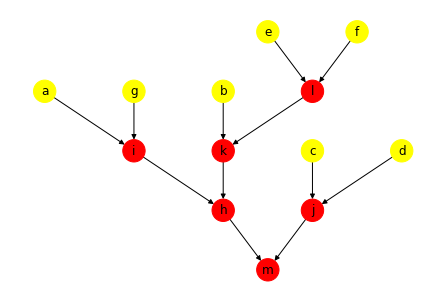

In [40]:
compute_cost(discretized, t_new, 1)

In [41]:
t_new

DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],            dtype=float32)

### Old cost

In [42]:
compute_cost(seqs, base_tree) ##when d & e were all zeros

DeviceArray(26., dtype=float32)

### test arbitrary sequence for d & e

In [43]:
test = jnp.array([[0, 0., 0., 0.],
                 [1., 0., 0., 1.],
                 [0., 1., 1., 0.],
                 [0., 0., 0., 0.],
                 [0., 0., 0., 0.]])

In [44]:
# compute_cost(test, t_new)